In [45]:
import torch
import gym
from gym import spaces 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer,GPTNeoForCausalLM, AutoTokenizer,GPT2LMHeadModel, AutoModelForCausalLM,BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util
import itertools
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from torch.distributions import Categorical
import torch.nn.functional as F
from copy import deepcopy
import json
from torch.distributions import Normal
import torch.optim as optim
import time
import os
from tqdm import tqdm
import logging
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
from collections import deque
import pandas as pd
import random
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import util
import matplotlib.pyplot as plt
from tqdm import tqdm
from huggingface_hub import login
from peft import LoraConfig, get_peft_model
from prettytable import PrettyTable
import seaborn as sb
from wordcloud import WordCloud

In [3]:
login()


In [4]:
ds = pd.read_json('/kaggle/input/ecommerce-dataset/Data/data_1.json')

ds.head()

,dialog_id,dialog
0,0,"[{'id': 0, 'role': 'customer', 'text': 'Hi, I'..."
1,1,"[{'id': 0, 'role': 'customer', 'text': 'Hello,..."
2,2,"[{'id': 0, 'role': 'customer', 'text': 'Hi the..."
3,3,"[{'id': 0, 'role': 'customer', 'text': 'Hello,..."
4,4,"[{'id': 0, 'role': 'customer', 'text': 'Hello!..."


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dialog_id  572 non-null    int64 
 1   dialog     572 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.1+ KB


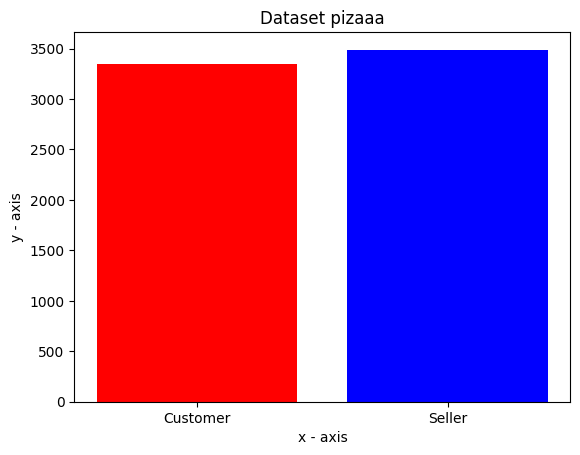

3350
3488


In [6]:
#anyalises dataset
with open('/kaggle/input/ecommerce-dataset/Data/data_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    # print(data)
utteracnes_customer = 0
utteracnes_seller = 0
for d in data:
  dialog = d['dialog']

  for idx in range(len(dialog)):
    if dialog[idx]['role'] == 'customer':
      # print(dialog[idx]['role'])
      utteracnes_customer +=1
    elif dialog[idx]['role'] == 'seller':
      utteracnes_seller +=1

c1 = ['red', 'blue']
height = (utteracnes_customer, utteracnes_seller)
bars = ('Customer', 'Seller')
plt.bar(bars, height, color = c1, width = 0.8)
plt.title("Dataset pizaaa")
plt.xlabel("x - axis")
plt.ylabel("y - axis")
plt.show()
print(utteracnes_customer)
print(utteracnes_seller)

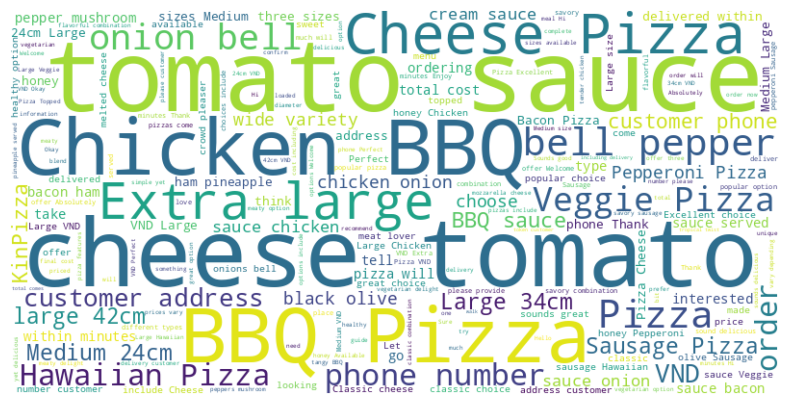

In [7]:
with open('/kaggle/input/ecommerce-dataset/Data/data_1.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
all_text = []
for d in data:
    dialog = d.get('dialog', [])
    for item in dialog:
        text = item.get('text', '')
        if isinstance(text, list):
            text = " ".join(str(t) for t in text)
        all_text.append(text)
combined_text = " ".join(all_text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
#confusion matrix
def confusion_maxtrix(dataset):
    pass

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [10]:
class CustomData(Dataset):
  def __init__(self, root, bert_token, bert_model, max_seq_len = 10):
    self.dialog_data = []
    self.states = []
    self.actions = []
    self.next_states = []
    self.max_seq_len = max_seq_len
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with open('/kaggle/input/ecommerce-dataset/Data/data_1.json', 'r', encoding='utf-8') as f:
      datas = json.load(f)

    self.tokenizer = bert_token
    self.bert_model = bert_model.to(self.device)
    self.bert_model.eval()
    self.bert_model.to(self.device)
      
      
    for data in datas:
        dialog = data['dialog']
        customer_utterances = []
        seller_utterances = []
        flag = 0

        for idx in range(len(dialog)):
          if dialog[idx]['role'] == 'customer':
            utterances = "<User>" + "/n" + dialog[idx]['text'] + "<End>" + "/n"
            # print('utterances', utterances)
            if flag == 0:
              customer_utterances.append(utterances)
              flag = 1
            else:
              customer_utterances[-1] += utterances


          if dialog[idx]['role'] == 'seller':
                        utterance = "<|Assistant|>\n" + dialog[idx]['text'] + "<|End|>\n"
                        # print('Seller_utterances', seller_utterances)
                        if flag == 1:
                            seller_utterances.append(utterance)
                            flag = 0
                        else:
                            seller_utterances[-1] += utterance
          history = ["<|Assistant|>/n I'm a KinPizza chatbot, what can I help you with?<|End|>/n"]
        #customer this dataset to states, actions, next_states
          for idx in range(len(seller_utterances)):
            sequence = history[-self.max_seq_len:] if len(history) >= self.max_seq_len else history[:]
            self.dialog_data.append(sequence)
            history.append(customer_utterances[idx])
            # print(history)
            self.states.append(''.join(history))
            self.actions.append(seller_utterances[idx])
            history.append(seller_utterances[idx])
            self.next_states.append(customer_utterances[idx+1] if idx+1 < len(seller_utterances) else "<|End|>")
            # self.dialog_data.append((self.states, self.actions,self.next_states))
            # print('next_states', self.next_states)
    

  def __len__(self):
        return len(self.actions)
      
  def encode_sequence(self, sequence):
      embedding = []
      for text in sequence:
          input = self.tokenizer(text, return_tensors = "pt", max_length = 128, truncation = True, padding = "max_length")
          input = {k: v.to(self.device) for k, v in input.items()}
          with torch.no_grad():
              output = self.bert_model(**input)
          embedding.append(output.last_hidden_state[:, 0, :].squeeze().cpu().numpy())

        
      while len(embedding) < self.max_seq_len:
          embedding.append(np.zeros(768))
      return np.stack(embedding)  
      


  def get_action(self, idx):
      print("Actions:", self.actions[idx])
      return self.actions[idx]


  def get_states(self, idx):
      print("States:", self.states[idx])
      return self.states[idx]
      
  # def get_dialog(self, idx):
  #     print("Dialog:", self.dialog_data[idx])
  #     return self.dialog_data[idx]


  def __getitem__(self, idx):
        # print("States:", self.states[idx])
        # print("Actions:", self.actions[idx])
        # print("Next states:", self.next_states[idx])
        sequence = self.encode_sequence(self.dialog_data[idx])  
        return (self.states[idx], self.actions[idx], self.next_states[idx])

    

In [11]:
dataset = '/kaggle/input/ecommerce-dataset/Data/data_1.json'
data = CustomData(dataset, bert_tokenizer, bert_model)
print(data.__getitem__(4))

("<|Assistant|>/n I'm a KinPizza chatbot, what can I help you with?<|End|>/n<User>/nHi, I'm interested in ordering a pizza from KinPizza. What types of pizzas do you offer?<End>/n", '<|Assistant|>\nWelcome! We have a wide variety of pizzas to choose from. Our most popular choices include:\n Cheese Pizza: A classic choice with cheese and cream sauce, served with honey.\n Chicken BBQ Pizza: A flavorful combination of cheese, tomato sauce, chicken, onion, bell pepper, and BBQ sauce.\n Veggie Pizza: A healthy option with cheese, tomato sauce, onion, bell pepper, mushroom, and black olive.\n Sausage Pizza: A meaty delight with cheese, tomato sauce, and sausage.\n Hawaiian Pizza: A unique twist on pizza with cheese, tomato sauce, bacon, ham, pineapple, and honey.\n Pepperoni Pizza: A crowd-pleaser with cheese, tomato sauce, and pepperoni.<|End|>\n', "<User>/nThat sounds great! I'm thinking about ordering the Cheese Pizza. What are the different sizes and prices?<End>/n")


In [12]:
print(data.__len__())

20639


In [13]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [14]:
class ActionSpace:
    def __init__(self, root_path, tokenizer, model):
        self.actions = []
        self.load_actions(root_path)
        self.all_action_space = []
        self.tokenizer = tokenizer
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def load_actions(self, root_path):
        with open(root_path, 'r', encoding='utf-8') as f:
            datas = json.load(f)
            for data in datas:
                dialog = data["dialog"]
                for turn in dialog:
                    if turn['role'] == "seller":
                        self.actions.append(turn['text'])

    def get_action(self, idx):
        if 0 <= idx < len(self.actions):
            return self.actions[idx]
        return None

    def get_all_action_space2(self):
        self.all_action_space = list(self.actions)
        return self.all_action_space

In [15]:
#define use LLM to compute consine of action space

action_space = ActionSpace(dataset, tokenizer, model)
# action_space.get_all_action_space2()

In [16]:
class Agent(nn.Module):
    def __init__(self, tokenizer, model, model_path=None, 
                 max_length=128, device=None):
        super(Agent, self).__init__()
        
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = self.setup_tokenizer(tokenizer)
        self.model = self.setup_model(model)
        self.max_length = max_length

        self.to(self.device)
        self.logger = logging.getLogger(__name__)

    def setup_tokenizer(self, tokenizer):
        """Thêm các token đặc biệt cho tokenizer."""
        SPECIAL_TOKENS_DICT = {"pad_token": "<pad>", "eos_token": "<|END|>"}
        new_tokens = ["<|Assistant|>", "<|User|>"]
        tokenizer.add_tokens(new_tokens)
        tokenizer.add_special_tokens(SPECIAL_TOKENS_DICT)
        return tokenizer

    def setup_model(self, model):
        """Resize token embeddings để hỗ trợ tokenizer mới."""
        model.resize_token_embeddings(len(self.tokenizer))
        return model

    def model_based_sampling(self, prompts, n_samples=1):
        """Sinh văn bản từ mô hình ngôn ngữ."""
        try:
            inputs = self.tokenizer(
                prompts, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                max_length=self.max_length
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_length=self.max_length,
                    num_return_sequences=n_samples,
                    do_sample=True,
                    top_k=50,
                    top_p=0.95,
                    temperature=1.0,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                    no_repeat_ngram_size=2,
                    early_stopping=True
                )

            results = []
            for i in range(0, len(outputs), n_samples):
                batch_outputs = outputs[i:i + n_samples]
                decoded = [
                    self.tokenizer.decode(out, skip_special_tokens=False).strip() 
                    for out in batch_outputs
                ]
                results.extend(decoded)

            return results
        except Exception as e:
            print(f"Error in model-based sampling: {e}")
            return [""] * len(prompts)

    def sampling(self, prompt, n_samples=1, max_length=None):
        """Sinh phản hồi cho 1 prompt."""
        if max_length is not None:
            self.max_length = max_length
        if isinstance(prompt, str):
            prompt = [prompt]
        return self.model_based_sampling(prompt, n_samples)

    def batch_sampling(self, prompts, n_samples=1, max_length=None):
        """Sinh phản hồi cho danh sách prompt."""
        if max_length is not None:
            self.max_length = max_length
        return self.model_based_sampling(prompts, n_samples)

    def forward(self, input_ids, attention_mask=None, **kwargs):
        """Cho phép dùng như mô hình nn.Module bình thường."""
        return self.model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    def __repr__(self):
        return f"Agent(device={self.device}, max_length={self.max_length})"


In [17]:
agent = Agent(tokenizer, model)

In [18]:
prompt = "I'll take the Medium Cheese Pizza with cream sauce and the Large Chicken BBQ Pizza. How much will that be in total?"
response = agent.sampling(prompt)
print(response)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


["I'll take the Medium Cheese Pizza with cream sauce and the Large Chicken BBQ Pizza. How much will that be in total?\n\nConversation 2:\nWaitress: Sure, your order will be $18.75.\nYou: Excellent, thank you!\nWaiter: Here is your bill. Enjoy your meal! \n<|endoftext|>\n\n\nMath--Fractions--Equivalent Fractions\nHey there! My name is Math Mastermind, and I'm here to take you on an exciting journey into the world of fractions. Today, we're going to explore the fascinating concept of equivalent fractions using the tones, knowledge"]


In [19]:
asd = agent.tokenizer(prompt)
print(asd)

{'input_ids': [40, 1183, 1011, 262, 13398, 27601, 20952, 351, 8566, 10746, 290, 262, 13601, 16405, 32083, 20952, 13, 1374, 881, 481, 326, 307, 287, 2472, 30], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        state, action, reward, next_state = zip(*random.sample(self.buffer, batch_size))
        return list(state), list(action), list(reward), list(next_state)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return list(self.buffer)[idx]
        else:
            return self.buffer[idx]


In [21]:
class QNetwork(nn.Module):
    def __init__(self, latent_state_dim=64, action_embedding_dim=32, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_state_dim + action_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Q-value output là 1 số thực
        )

    def forward(self, x):
        return self.net(x)

In [22]:
class WorldModel(nn.Module):
    def __init__(self, observation_dim=768, latent_state_dim=64, num_actions=3500, 
                 action_embedding_dim=32, hidden_dim=256, num_responses=5):
        super(WorldModel, self).__init__()
        
        self.observation_dim = observation_dim
        self.latent_state_dim = latent_state_dim
        self.num_actions = num_actions
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=observation_dim, nhead=8, dim_feedforward=512),
            num_layers=2
        )
        
        self.state_projector = nn.Linear(observation_dim, latent_state_dim)
        self.action_embedding = nn.Embedding(num_actions, action_embedding_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(latent_state_dim + action_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_state_dim + 1)  # next_state + reward
        )
        
        self.response_head = nn.Linear(latent_state_dim, num_responses)

    def forward(self, observation, action):
        # Get the model's device
        device = next(self.parameters()).device

        # Move inputs to model device
        observation = observation.to(device)
        action = action.to(device)

        # 🔍 Debug: Check if action index is valid
        if torch.any(action >= self.num_actions) or torch.any(action < 0):
            raise ValueError(f"[WorldModel] Invalid action index! Max: {action.max().item()}, Min: {action.min().item()}, Expected: [0, {self.num_actions - 1}]")


        # Transformer expects shape: (seq_len, batch_size, obs_dim)
        observation = observation.transpose(0, 1)  # (seq_len, batch_size, obs_dim)
        transformer_output = self.transformer_encoder(observation)
        transformer_output = transformer_output.transpose(0, 1)  # (batch_size, seq_len, obs_dim)
        
        # Take the last token’s output
        state = transformer_output[:, -1, :]  # (batch_size, obs_dim)
        latent_state = self.state_projector(state)  # (batch_size, latent_dim)

        # Embed action
        action_embed = self.action_embedding(action)  # (batch_size, action_embed_dim)

        # Concatenate and pass through FC
        x = torch.cat([latent_state, action_embed], dim=1)  # (batch_size, latent + embed)

        # Check for NaNs or infs
        if torch.isnan(x).any() or torch.isinf(x).any():
            raise ValueError("[WorldModel] Detected NaN or Inf in input to fc layer")

        out = self.fc(x)  # (batch_size, latent_dim + 1)
        next_state = out[:, :-1]  # (batch_size, latent_dim)
        reward = out[:, -1]       # (batch_size,)

        # Predict response logits from latent
        response_logits = self.response_head(latent_state)  # (batch_size, num_responses)

        return next_state, reward, response_logits


In [23]:
class Reward():
    def __init__():
        pass

In [24]:
data.__getitem__(1)

#state
#action
#next state

("<|Assistant|>/n I'm a KinPizza chatbot, what can I help you with?<|End|>/n<User>/nHi, I'm interested in ordering a pizza from KinPizza. What types of pizzas do you offer?<End>/n",
 '<|Assistant|>\nWelcome! We have a wide variety of pizzas to choose from. Our most popular choices include:\n Cheese Pizza: A classic choice with cheese and cream sauce, served with honey.\n Chicken BBQ Pizza: A flavorful combination of cheese, tomato sauce, chicken, onion, bell pepper, and BBQ sauce.\n Veggie Pizza: A healthy option with cheese, tomato sauce, onion, bell pepper, mushroom, and black olive.\n Sausage Pizza: A meaty delight with cheese, tomato sauce, and sausage.\n Hawaiian Pizza: A unique twist on pizza with cheese, tomato sauce, bacon, ham, pineapple, and honey.\n Pepperoni Pizza: A crowd-pleaser with cheese, tomato sauce, and pepperoni.<|End|>\n',
 '<|End|>')

In [25]:
class RealEnvironment(gym.Env):
    def __init__(self, file_path, action_space_dict, bert_tokenizer, bert_model):
        super(RealEnvironment, self).__init__()
        self.data = CustomData(file_path, bert_tokenizer, bert_model)  # Khởi tạo self.data
        self.action_space_dict = action_space.get_all_action_space2()  # Sửa: không gọi get_all_action_space2()
        self.index_to_action = {i: action for i, action in enumerate(self.action_space_dict)}
        self.action_to_index = {action: i for i, action in enumerate(self.action_space_dict)}

        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()

        self.observation_space = spaces.Text(max_length=2048)
        self.action_space = spaces.Discrete(len(self.action_space_dict))

        self.current_dialog = None
        self.dialog_history = []
        self.step_idx = 0

    def _encode_text(self, text):
        inputs = self.bert_tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding='max_length')
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

    def reset(self):
        self.current_dialog = random.randint(0, len(self.data) - 1)
        self.dialog_history = ["<|Assistant|> I'm a KinPizza chatbot, what can I help you with? <|End|>"]
        self.step_idx = 0

        # Lấy trạng thái đầu tiên
        _, _, next_state = self.data[self.current_dialog]
        self.dialog_history.append(next_state)
        return " ".join(self.dialog_history)

    def step(self, action):
        done = False
        info = {}
        reward = 0.0  # default
    
        action_text = self.index_to_action.get(action, self.index_to_action[0])
        self.dialog_history.append(action_text)
    
        if self.step_idx < len(self.data) - self.current_dialog:
            sample = self.data[self.current_dialog + self.step_idx]
            if len(sample) == 4:
                _, _, next_state, reward = sample
            else:
                _, _, next_state = sample
                reward = 0.0
    
            self.dialog_history.append(next_state)
            self.step_idx += 1
            obs = next_state
    
            if next_state == "<|End|>":
                done = True
        else:
            obs = "<|End|>"
            done = True
    
        return obs, float(reward), done, info


    def render(self, mode="human"):
        print("\n=== Dialog History (Real) ===")
        for i, text in enumerate(self.dialog_history):
            role = "customer" if i % 2 == 0 else "seller"
            print(f"Turn {i+1} ({role}): {text}")

In [26]:
action_arr = action_space.get_all_action_space2()
# print(action_arr)
print(len(action_arr))

3488


In [27]:
class VirtualEnvironment(gym.Env):
    def __init__(self, world_model, action_space, bert_token, bert_model, max_seq_len=10, state_dim=768):
        super(VirtualEnvironment, self).__init__()
        self.world_model = world_model
        self.action_space_dict = action_space.get_all_action_space2()
        self.index_to_action = {i: action for i, action in enumerate(self.action_space_dict)}
        self.action_to_index = {action: i for i, action in enumerate(self.action_space_dict)}

        self.observation_space = spaces.Text(max_length=2048)
        self.action_space = spaces.Discrete(len(self.action_space_dict))

        self.tokenizer = bert_token
        self.bert_model = bert_model
        self.bert_model.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert_model.to(self.device)

        self.max_seq_len = max_seq_len
        self.dialog_history = []
        self.current_sequence = []
        self.possible_responses = action_space.get_all_action_space2()

    def encode_text(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding='max_length')
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    def encode_sequence(self, sequence):
        embedding = []
        for text in sequence[-self.max_seq_len:]:  # chỉ lấy phần mới nhất
            inputs = self.tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
            embedding.append(outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy())
        while len(embedding) < self.max_seq_len:
            embedding.insert(0, np.zeros(768))
        return embedding

    def reset(self):
        self.dialog_history = []
        initial_texts = [
            "<User> Hi, I'm interested in ordering a pizza from KinPizza. What types of pizzas do you offer? <End>",
            "<User> What's the price of this pizza? <End>",
            "<User> Do you have any vegetarian options? <End>"
        ]
        initial_obs = random.choice(initial_texts)
        self.dialog_history.append(initial_obs)
        self.current_sequence = [initial_obs]
        return initial_obs

    def step(self, action):
        done = False
        reward = 0.0
        info = {}
    
        # Lấy action text từ index
        action_text = self.index_to_action.get(action, self.index_to_action[0])
        self.dialog_history.append(action_text)
        self.current_sequence.append(action_text)
    
        # Encode sequence đúng định dạng (1, seq_len, 768)
        seq_emb = self.encode_sequence(self.current_sequence)  # list of np.array
        seq_emb = np.stack(seq_emb)  # (seq_len, 768)
        sequence_tensor = torch.tensor(seq_emb, dtype=torch.float32).unsqueeze(0).to(self.device)  # (1, seq_len, 768)
    
        # Action index (đã là int)
        # action_idx = action
        action_idx = self.action_to_index.get(action)
        print(action_idx)
        action_tensor = torch.tensor([action_idx], dtype=torch.long).to(self.device)  # (1,)
    
        with torch.no_grad():
            next_state, reward_tensor, response_logits = self.world_model(sequence_tensor, action_tensor)
    
            response_probs = torch.softmax(response_logits, dim=-1)
            response_idx = Categorical(probs=response_probs).sample().item()
            reward = reward_tensor.item()
    
        # 🟢 Sinh phản hồi từ response index
        obs = self.possible_responses[min(response_idx, len(self.possible_responses)-1)]
        self.dialog_history.append(obs)
        self.current_sequence.append(obs)
    
        if obs == "<|End|>":
            done = True
    
        return " ".join(self.dialog_history), reward, done, info
    


In [28]:
class WorldModelTrainer:
    def __init__(self, world_model, bert_tokenizer, bert_model, state_dim, action_space_dict, max_seq_len = 10):
        self.world_model = world_model
        self.criterion_state = nn.MSELoss()
        self.criterion_reward = nn.MSELoss()
        self.criterion_response = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(world_model.parameters(), lr=0.001)
        self.state_dim = state_dim
        self.max_seq_len = max_seq_len
        self.possible_responses = action_space_dict
        self.action_to_index = {action: i for i, action in enumerate(action_space_dict)}
        self.tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bert_model.to(self.device)
        self.world_model.to(self.device)

    def _encode_text(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", max_length=128, truncation=True, padding='max_length').to(self.device)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    def train(self, replay_buffer, num_epochs=100, batch_size=64):
        if len(replay_buffer) < batch_size:
            print("Replay buffer too small for training. Need at least", batch_size, "samples.")
            return
    
        for epoch in range(num_epochs):
            total_loss = 0.0
            num_batches = len(replay_buffer) // batch_size
            if num_batches == 0:
                continue
    
            for i in range(0, len(replay_buffer), batch_size):
                batch = list(itertools.islice(replay_buffer.buffer, i, i + batch_size))
                sequences, actions, rewards, next_states = zip(*batch)
    
                # Encode sequences (dialog state) to BERT embeddings
                inputs_seq = self.tokenizer(list(sequences), return_tensors="pt", padding=True, truncation=True, max_length=128)
                inputs_seq = {k: v.to(self.device) for k, v in inputs_seq.items()}
                with torch.no_grad():
                    outputs_seq = self.bert_model(**inputs_seq)
                    sequence_tensors = outputs_seq.last_hidden_state  # (batch_size, seq_len, 768)
    
                # Encode next_states (ground-truth response) to BERT embeddings
                next_states = [str(s) for s in next_states]
                inputs_next = self.tokenizer(next_states, return_tensors="pt", padding=True, truncation=True, max_length=128)
                inputs_next = {k: v.to(self.device) for k, v in inputs_next.items()}
                with torch.no_grad():
                    outputs_next = self.bert_model(**inputs_next)
                    next_state_tensors = outputs_next.last_hidden_state  # (batch_size, seq_len, 768)
    
                # Map actions to indices
                action_tensors = torch.tensor([self.action_to_index.get(a, 0) for a in actions], dtype=torch.long).to(self.device)
                reward_tensors = torch.tensor([float(r) for r in rewards], dtype=torch.float32).to(self.device)
    
                # Convert next_states to class labels (for response classification)
                response_indices = torch.tensor([
                    self.possible_responses.index(ns) if ns in self.possible_responses else 0
                    for ns in next_states
                ], dtype=torch.long).to(self.device)
    
                # Forward pass
                self.optimizer.zero_grad()
                output = self.world_model(sequence_tensors, action_tensors)  # (batch_size, latent + 1)
    
                # Tách output thành next_state_pred và reward_pred
                next_state_pred, reward_pred, response_logits = self.world_model(sequence_tensors, action_tensors)       # (batch_size,)
    
                # Encode next_state ground truth into latent
                actual_next_state = self.world_model.state_projector(next_state_tensors[:, -1, :]).to(self.device)  # Lấy token cuối
    
                # Loss functions
                loss_state = self.criterion_state(next_state_pred, actual_next_state)
                loss_reward = self.criterion_reward(reward_pred, reward_tensors)
    
                # Optional: Classification loss
                response_logits = next_state_pred @ torch.randn(next_state_pred.size(1), len(self.possible_responses)).to(self.device)
                loss_response = self.criterion_response(response_logits, response_indices)
    
                # Combine losses
                loss = loss_state + loss_reward + loss_response
                loss.backward()
                self.optimizer.step()
    
                total_loss += loss.item()
    
            print(f"Epoch {epoch+1}, Loss: {total_loss / num_batches:.4f}")


In [29]:
class Actor(nn.Module):
    def __init__(self, latent_state_dim=64, num_actions=1000, hidden_dim=256):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions)  # Xuất ra logits cho num_actions
        )

    def forward(self, state):
        logits = self.net(state)
        dist = Categorical(logits=logits)
        action_indices = dist.sample()
        log_prob = dist.log_prob(action_indices)
        return action_indices, log_prob

In [30]:
class Critic(nn.Module):
    def __init__(self, latent_state_dim=64, action_embedding_dim=32, hidden_dim=256):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_state_dim + action_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Q-value output
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))

In [31]:
class MBPO:
    def __init__(self, real_env, virtual_env, action_space_dict,tokenizer, model, observation_dim=768, latent_state_dim=64, action_embedding_dim=32,
                 discount=0.9, lr=1e-5, buffer_capacity=100000, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1,
                 tau=0.05, target_update_freq=1000):
        self.real_env = real_env
        self.virtual_env = virtual_env
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.target_update_freq = target_update_freq
        self.observation_dim = observation_dim
        self.latent_state_dim = latent_state_dim
        self.action_embedding_dim = action_embedding_dim
        self.training_step = 0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        #bert
        self.tokenizer = tokenizer
        self.model = model
        # Initialize action mapping
        self.action_space_dict = action_space_dict
        self.num_actions = len(action_space_dict)
        self.action_to_index = {action: i for i, action in enumerate(action_space_dict)}
        self.index_to_action = {i: action for i, action in enumerate(action_space_dict)}

        # Initialize networks
        self.world_model = WorldModel(observation_dim, latent_state_dim, self.num_actions, action_embedding_dim).to(self.device)
        self.qnet = QNetwork(latent_state_dim, action_embedding_dim).to(self.device)
        self.q_target = deepcopy(self.qnet).to(self.device)
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=lr)
        self.world_model_optimizer = optim.Adam(self.world_model.parameters(), lr=lr)

        # SAC components
        self.actor = Actor(latent_state_dim, self.num_actions).to(self.device)
        self.critic_1 = Critic(latent_state_dim, action_embedding_dim).to(self.device)
        self.critic_2 = Critic(latent_state_dim, action_embedding_dim).to(self.device)
        self.target_critic_1 = deepcopy(self.critic_1).to(self.device)
        self.target_critic_2 = deepcopy(self.critic_2).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        self.log_alpha = torch.tensor(np.log(0.1), requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)
        self.target_entropy = torch.tensor(-self.num_actions, dtype=torch.float32, device=self.device)

        # Reward model
        self.reward_model = SentenceTransformer('all-MiniLM-L6-v2').to(self.device)
        self.embedding_cache = {}
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

    def compute_reward(self, action, next_state):
        length_reward = semantic_reward = 0.0
        if action:
            normalized_length = min(len(action) / 256, 1.0)
            length_reward = 0.2 * (1 / (1 + math.exp(-5 * (normalized_length - 0.5))))
        a_emb = self.reward_model.encode(action, convert_to_tensor=True, device=self.device)
        n_emb = self.reward_model.encode(next_state, convert_to_tensor=True, device=self.device)
        similarity = util.cos_sim(a_emb, n_emb).item()
        if similarity >= 0.8:
            semantic_reward = 0.5 * max(0, similarity)
        return max(-1.0, min(1.0, length_reward + semantic_reward))

    def train_model(self, batch_size=128):
        if len(self.replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
        states = [str(s) if not isinstance(s, str) else s for s in states]
        next_states = [str(s) if not isinstance(s, str) else s for s in next_states]

        states_encoded = self.tokenizer(states, convert_to_tensor=True, show_progress_bar=False).to(self.device)
        next_states_encoded = self.tokenizer(next_states, convert_to_tensor=True, show_progress_bar=False).to(self.device)
        # states_encoded = states_encoded.unsqueeze(1)
        # next_states_encoded = next_states_encoded.unsqueeze(1)

        action_indices = torch.LongTensor([self.action_to_index.get(action, 0) for action in actions]).to(self.device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        response_indices = torch.LongTensor([self.virtual_env.possible_responses.index(ns) if ns in self.virtual_env.possible_responses else 0 for ns in next_states]).to(self.device)
        
        print("states_encoded shape:", states_encoded.shape)

        next_latent_states = self.world_model.state_projector(self.world_model.transformer_encoder(next_states_encoded)[:, -1, :]).to(self.device)
        pred_next_states, pred_rewards, response_logits = self.world_model(states_encoded, action_indices).to(self.device)

        loss_state = nn.MSELoss()(pred_next_states, next_latent_states)
        loss_reward = nn.MSELoss()(pred_rewards, rewards_tensor)
        loss_response = nn.CrossEntropyLoss()(response_logits, response_indices)
        loss = loss_state + loss_reward + loss_response

        self.world_model_optimizer.zero_grad()
        loss.backward()
        self.world_model_optimizer.step()

    def rollout_model(self, n_rollout=5):
        if len(self.replay_buffer) < 128:
            return
        states, _, _, _ = self.replay_buffer.sample(128)
        states = [str(s) if not isinstance(s, str) else s for s in states]
        states_encoded = self.reward_model.encode(states, convert_to_tensor=True, show_progress_bar=False).to(self.device)
        states_encoded = states_encoded.unsqueeze(1)

        actions = torch.randint(0, self.num_actions, (128,)).to(self.device)

        with torch.no_grad():
            next_states, rewards, response_logits = self.world_model(states_encoded, actions).to(self.device)
            response_probs = torch.softmax(response_logits, dim=-1)
            response_indices = Categorical(probs=response_probs).sample()

        action_strings = [self.index_to_action[idx.item()] for idx in actions]
        next_state_strings = [self.virtual_env.possible_responses[min(idx.item(), len(self.virtual_env.possible_responses)-1)] for idx in response_indices]

        for s, a, r, ns in zip(states, action_strings, rewards.cpu().numpy(), next_state_strings):
            self.replay_buffer.push(s, a, r.item(), ns)

    def train_policy(self, batch_size=64, gamma=0.99):
        if len(self.replay_buffer) < batch_size:
            return  # Không đủ dữ liệu để huấn luyện
    
        # Lấy batch dữ liệu từ buffer
        # batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states =self.replay_buffer.sample(batch_size)
        # Encode state và next_state bằng tokenizer
        states_encoded = self.tokenizer(list(states), return_tensors='pt', padding=True, truncation=True).to(self.device)
        next_states_encoded = self.tokenizer(list(next_states), return_tensors='pt', padding=True, truncation=True).to(self.device)
        action_encoded = self.tokenizer(list(actions), return_tensors = 'pt', padding = True, truncation = True).to(self.device)
        # Lấy đầu ra từ mô hình pretrained (BERT hoặc tương đương)
        with torch.no_grad():
            states_encoded = self.model(**states_encoded).last_hidden_state
            next_states_encoded = self.model(**next_states_encoded).last_hidden_state
            action_encoded = self.model(**action_encoded).last_hidden_state

        print("size of states encode without unsqueeze", states_encoded.shape)
        
        # Encode latent representation bằng transformer và projector
        latent_states = self.world_model.state_projector(self.world_model.transformer_encoder(states_encoded)[:, -1, :])
        latent_next_states = self.world_model.state_projector(self.world_model.transformer_encoder(next_states_encoded)[:, -1, :])
        latent_action_states = self.world_model.state_projector(self.world_model.transformer_encoder(action_encoded)[:, -1, :])
        
        # Encode action thành one-hot vector hoặc latent space (tuỳ vào định nghĩa)
        if isinstance(actions[0], str):
            action_indices = torch.tensor([self.action_to_index[a] for a in actions], dtype=torch.long).to(self.device)
            action_embeddings = self.world_model.action_embedding(action_indices)
        else:
            action_embeddings = torch.tensor(actions, dtype=torch.float).to(self.device)
    
        # Phần thưởng và done
        rewards_tensor = torch.tensor(rewards, dtype=torch.float).unsqueeze(1).to(self.device)
        # dones_tensor = torch.tensor(dones, dtype=torch.float).unsqueeze(1).to(self.device)

        # #update critic
        # with torch.no_grad():
        #     next_actions, next_log_probs = self.actor(latent_next_states)
        #     next_q1 = self.target_critic_1(latent_next_states, next_actions)
        #     next_q1 = self.target_critic_2(latent_next_states, next_actions)
        #     next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_probs
        #     target_q = rewards_tensor + gamma  next_q

        # q1 = self.critic_1(latent_states, action_indices)
        # q2 = self.critic_2(latent_states, action_indices)
        # critic_loss = F.mse_loss(q1, target_q) + F.mse_loss(q2, target_q)
        # self.critic_1_optimizer.zero_grad()
        # self.critic_2_optimizer.zero_grad()
        # critic_loss.backward()
        # self.critic_1_optimizer.step()
        # self.critic_2_optimizer.step()

        # #update actor
        # new_actions, log_probs = self.actor(latent_space)
        # q1_value = self.critic_1(latent_states, new_actions)
        # q2_value = self.critic_2(latent_states, new_action)
        # q_value = torch.min(q1_value, q2_value)
        # actor_loss = (self.alpha * log_probs - q_value).mean()
        # self.actor_optimizer.zero_grad()
        # actor_loss.backward()
        # self.actor_optimizer.step()
        
        # #update alpha
    
        # alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        # self.alpha_optimizer.zero_grad()
        # alpha_loss.backward()
        # self.alpha_optimizer.step()
        # self.alpha = self.log_alpha.exp()
        # Dự đoán phần thưởng và trạng thái kế tiếp từ World Model
        predicted_next_state, predicted_reward, _ = self.world_model(states_encoded, action_indices)

        # predicted_reward = self.world_model.reward_predictor(torch.cat([latent_states, action_embeddings], dim=-1))
        # predicted_next_state = self.world_model.transition_model(torch.cat([latent_states, action_embeddings], dim=-1))
    
        # Tính loss
        reward_loss = F.mse_loss(predicted_reward, rewards_tensor)
        state_loss = F.mse_loss(predicted_next_state, latent_next_states)
    
        # Cộng lại loss
        total_loss = reward_loss + state_loss
    
        # Tối ưu
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
    
        print(f"Train policy loss: {total_loss.item():.4f}")


    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            state = str(state) if not isinstance(state, str) else state
            state_emb = self.reward_model.encode(state, convert_to_tensor=True, show_progress_bar=False).to(self.device)
            state_emb = state_emb.unsqueeze(0).unsqueeze(0)
            latent_state = self.world_model.state_projector(self.world_model.transformer_encoder(state_emb)[:, -1, :]).to(self.device)
            with torch.no_grad():
                action_indices, _ = self.actor(latent_state)
            return action_indices.item()

    def train(self, dataset, epochs=5, batch_size=64, max_steps=500):
        print("Collecting initial samples...")
        self.real_env.reset() 
        for _ in range(100):  # Warm-up với 100 mẫu đầu tiên
            state = random.choice(dataset)[0]  # state là đoạn embedding
            action = self.select_action(state)  # trả về chỉ số (index)
            next_state,reward, done, _ = self.real_env.step(action) 
            action_text = self.index_to_action[action]
    
            # Kiểm tra để tránh bug
            assert isinstance(reward, (float, int)), f"Expected reward to be float, got: {type(reward)}"
            assert isinstance(next_state, str), f"Expected next_state to be str, got: {type(next_state)}"
    
            self.replay_buffer.push(state, action_text, reward, next_state)
    
        for epoch in range(epochs):
            print(f"\n[Epoch {epoch + 1}/{epochs}]")
    
            # Huấn luyện World Model bằng dữ liệu thật
            world_trainer = WorldModelTrainer(
                self.world_model,
                self.tokenizer,
                self.model,
                self.observation_dim,          
                self.action_space_dict,
            )
            world_trainer.train(self.replay_buffer, num_epochs = 5, batch_size=batch_size)
    
            # Sinh dữ liệu ảo từ World Model
            for _ in range(max_steps):
                state = random.choice(dataset)[0]
                action = self.select_action(state)
                
                action_text = self.index_to_action[action]
                # print(action_text)
                #eturn " ".join(self.dialog_history), reward, done, info
                next_state, reward, done, _ = self.virtual_env.step(action_text)

                print("Reward:", reward, "Type:", type(reward))

                self.replay_buffer.push(state, action_text, reward, next_state)
    
            # Cập nhật chính sách bằng dữ liệu từ buffer
                self.train_policy(batch_size=batch_size)

    def save_model(self, save_path="mbpo_model"):
        os.makedirs(save_path, exist_ok=True)
    
        torch.save({
            'world_model_state_dict': self.world_model.state_dict(),
            'qnet_state_dict': self.qnet.state_dict(),
            'actor_state_dict': self.actor.state_dict(),
            'critic_1_state_dict': self.critic_1.state_dict(),
            'critic_2_state_dict': self.critic_2.state_dict(),
            'log_alpha': self.log_alpha,
            'optimizer_qnet': self.optimizer.state_dict(),
            'optimizer_world_model': self.world_model_optimizer.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_1_optimizer': self.critic_1_optimizer.state_dict(),
            'critic_2_optimizer': self.critic_2_optimizer.state_dict(),
            'alpha_optimizer': self.alpha_optimizer.state_dict(),
        }, os.path.join(save_path, "mbpo_full_model.pt"))
    
        print(f" Saved MBPO model to {save_path}")


In [32]:
class ModelTester:
    def __init__(self, mbpo, replay_buffer, action_space_dict, agent, sentence_transformer, real_env, virtual_env):
        self.mbpo = mbpo
        self.replay_buffer = replay_buffer
        self.action_space_dict = action_space_dict
        self.agent = agent
        self.sentence_transformer = sentence_transformer
        self.real_env = real_env
        self.virtual_env = virtual_env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def test_model(self, test_data=None, num_episodes=100, use_real_env=True, ground_truth_responses=None, output_file="test_results.json"):
        start_time = time.time()
        results = {
            "average_reward": 0.0,
            "semantic_similarity": 0.0,
            "response_diversity": 0.0,
            "valid_action_rate": 0.0,
            "computation_time": 0.0,
            "responses": [],
            "errors": []
        }
        rewards = []
        similarities = []
        action_indices = []
        valid_actions = 0
        env = self.real_env if use_real_env else self.virtual_env

        for episode in range(num_episodes):
            # Khởi tạo trạng thái
            state = test_data[episode] if test_data and episode < len(test_data) else env.reset()
            done = False
            episode_rewards = []
            episode_actions = []
            episode_responses = []

            while not done:
                # Chọn hành động
                action_idx = self.mbpo.select_action(state)
                action_text = self.mbpo.index_to_action.get(action_idx, "Sorry, I couldn't process your request. Please try again.")
                if action_text == "Sorry, I couldn't process your request. Please try again.":
                    results["errors"].append({
                        "episode": episode,
                        "action_idx": action_idx,
                        "state": state
                    })
                else:
                    valid_actions += 1

                # Tinh chỉnh phản hồi bằng Phi-2
                response = self.agent.model_based_sampling(action_text)
                episode_responses.append({
                    "state": state,
                    "action_idx": action_idx,
                    "response": response,
                    "action_text": action_text
                })

                # Bước tiếp theo trong môi trường
                next_state, reward, done, _ = env.step(action_idx)
                episode_rewards.append(reward)
                episode_actions.append(action_idx)

                # Tính độ tương đồng ngữ nghĩa
                target_text = ground_truth_responses[episode] if ground_truth_responses and episode < len(ground_truth_responses) else next_state
                a_emb = self.sentence_transformer.encode(response, convert_to_tensor=True, device=self.device)
                b_emb = self.sentence_transformer.encode(target_text, convert_to_tensor=True, device=self.device)

                # a_emb = a_emb.unsqueeze(0)
                # b_emb = b_emb.unsqueeze(0)

                similarity = util.cos_sim(a_emb, b_emb)[0][0].item()


                similarities.append(similarity)

                state = next_state

            rewards.append(np.mean(episode_rewards))
            action_indices.extend(episode_actions)
            results["responses"].extend(episode_responses)

        # Tính các chỉ số
        results["average_reward"] = np.mean(rewards) if rewards else 0.0
        results["semantic_similarity"] = np.mean(similarities) if similarities else 0.0
        results["response_diversity"] = len(set(action_indices)) / self.mbpo.num_actions if action_indices else 0.0
        results["valid_action_rate"] = valid_actions / (num_episodes * len(episode_actions)) if episode_actions else 0.0
        results["computation_time"] = time.time() - start_time

        # Lưu kết quả
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=4)

        return results

    def print_results(self, results):
        """In ra kết quả kiểm tra."""
        print(f"Average Reward: {results['average_reward']:.4f}")
        print(f"Semantic Similarity: {results['semantic_similarity']:.4f}")
        print(f"Response Diversity: {results['response_diversity']:.4f}")
        print(f"Valid Action Rate: {results['valid_action_rate']:.4f}")
        print(f"Computation Time: {results['computation_time']:.2f} seconds")
        print(f"Number of Errors: {len(results['errors'])}")
        print("\nSample Responses:")
        for i, response in enumerate(results["responses"][:5]):
            print(f"Episode {i}:")
            print(f"  State: {response['state']}")
            print(f"  Action Index: {response['action_idx']}")
            print(f"  Response: {response['response']}")
            print(f"  Action Text: {response['action_text']}")
        if results["errors"]:
            print("\nErrors:")
            for error in results["errors"][:5]:
                print(f"Episode {error['episode']}: Invalid action_idx {error['action_idx']} for state {error['state']}")

In [33]:
INPUT_DIM = 384
ACTION_DIM = 384
STATE_DIM = 384


In [34]:
actor = Actor(384, 384)
critic = Critic(384, 384)

In [35]:
print(ds)

     dialog_id                                             dialog
0            0  [{'id': 0, 'role': 'customer', 'text': 'Hi, I'...
1            1  [{'id': 0, 'role': 'customer', 'text': 'Hello,...
2            2  [{'id': 0, 'role': 'customer', 'text': 'Hi the...
3            3  [{'id': 0, 'role': 'customer', 'text': 'Hello,...
4            4  [{'id': 0, 'role': 'customer', 'text': 'Hello!...
..         ...                                                ...
567        611  [{'id': 0, 'role': 'customer', 'text': 'Hello,...
568        613  [{'id': 0, 'role': 'customer', 'text': 'Hi, I'...
569        614  [{'id': 0, 'role': 'customer', 'text': 'Hello,...
570        615  [{'id': 0, 'role': 'customer', 'text': 'Hi, I'...
571        616  [{'id': 0, 'role': 'customer', 'text': 'Hi, I'...

[572 rows x 2 columns]


In [36]:
train, test= train_test_split(ds, test_size = 0.2, random_state = 42)

In [37]:
print(data.__getitem__(1))

("<|Assistant|>/n I'm a KinPizza chatbot, what can I help you with?<|End|>/n<User>/nHi, I'm interested in ordering a pizza from KinPizza. What types of pizzas do you offer?<End>/n", '<|Assistant|>\nWelcome! We have a wide variety of pizzas to choose from. Our most popular choices include:\n Cheese Pizza: A classic choice with cheese and cream sauce, served with honey.\n Chicken BBQ Pizza: A flavorful combination of cheese, tomato sauce, chicken, onion, bell pepper, and BBQ sauce.\n Veggie Pizza: A healthy option with cheese, tomato sauce, onion, bell pepper, mushroom, and black olive.\n Sausage Pizza: A meaty delight with cheese, tomato sauce, and sausage.\n Hawaiian Pizza: A unique twist on pizza with cheese, tomato sauce, bacon, ham, pineapple, and honey.\n Pepperoni Pizza: A crowd-pleaser with cheese, tomato sauce, and pepperoni.<|End|>\n', '<|End|>')


In [38]:
action_list = action_space.get_all_action_space2()
action_dim = len(action_list)
print(action_dim)
world_model = WorldModel(observation_dim = 768, latent_state_dim = 64, num_actions = 3500, action_embedding_dim = 32)

3488


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [39]:
replay_buffer = ReplayBuffer(100000)

In [40]:
real_env = RealEnvironment(dataset, action_space, bert_tokenizer, bert_model)
vir_env = VirtualEnvironment(world_model, action_space, bert_tokenizer, bert_model)
action_space_dict = action_space.get_all_action_space2()
mbpo = MBPO(real_env, vir_env, action_space_dict, bert_tokenizer, bert_model)
# mbpo.setup_action_mapping(action_space)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [41]:
# mbpo = MBPO(real_env, virtual_env, action_space_dict)
mbpo.train(dataset, epochs=2, batch_size=16, max_steps=500)


[Epoch 1/2]
Epoch 1, Loss: 14.2542
Epoch 2, Loss: 12.8458
Epoch 3, Loss: 13.2952
Epoch 4, Loss: 12.1110
Epoch 5, Loss: 10.3293
545
Reward: 0.24209435284137726 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7288
600
Reward: 0.03406248986721039 Type: <class 'float'>


/tmp/ipykernel_31/4280453118.py:193: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reward_loss = F.mse_loss(predicted_reward, rewards_tensor)


size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7429
2948
Reward: 0.2579811215400696 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7693
1370
Reward: 0.1246580183506012 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7703
1118
Reward: 0.25682333111763 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7993
2178
Reward: 0.4080456793308258 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7140
2490
Reward: 0.025077316910028458 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7651
1997
Reward: 0.1179838627576828 Type: <class 'float'>
size of states encode without unsqueeze torch.Size([16, 3, 768])
Train policy loss: 3.7421
57
Reward: 0.09769038110971451 Type: <c

In [42]:
test_data = [
    "Customer: I want a large Chicken BBQ Pizza.",
    "Customer: How much is a medium Pepperoni Pizza?",
    "Customer: Can you deliver in 20 minutes?",
    "Customer: Any promotions today?"
]
ground_truth_responses = [
    "Perfect choice! The total cost for a large Chicken BBQ Pizza is 269,000 VND.",
    "The total cost for a medium Pepperoni Pizza is 179,000 VND.",
    "We'll try our best to deliver within 30 minutes.",
    "Today we have a 10% discount on all large pizzas!"
]

In [ ]:
# Khởi tạo tester
tester = ModelTester(mbpo, replay_buffer, mbpo.action_space_dict, agent, mbpo.reward_model, real_env, vir_env)

# Chạy test
results = tester.test_model(
    test_data=test_data,
    num_episodes=100,
    use_real_env=True,  
    ground_truth_responses=ground_truth_responses,
    output_file="test_results.json"
)

# In kết quả


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [ ]:
tester.print_results(results)

In [ ]:
import nbformat

path = "your_notebook.ipynb"

with open(path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

with open(path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("Đã loại bỏ metadata.widgets")
